In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
import os
import time
import copy
import torchvision
from tqdm import tqdm

# set seed
torch.manual_seed(69420)

# Datasets

In [2]:
!rm -r ./train
!unzip -q "../input/warmup-cat-and-dog-classification/train.zipfile" -d ./
!cd ./train && dir
!rm -r ./test
!unzip -q "../input/warmup-cat-and-dog-classification/test.zipfile" -d ./

rm: cannot remove './train': No such file or directory
cat  dog
rm: cannot remove './test': No such file or directory


## Data Transform & Normalize

In [3]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]

data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])


# Model

### Config

In [4]:
class configure:
    def __init__(self):
        self.num_epochs = 4
        self.batch_size = 256
        self.lr = 1e-3
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classes_dict = {} # Empty at first
    
    def set_classes(self, classeslist):
        for idx, classes in enumerate(classeslist):
            self.classes_dict.update({f'{idx}': f'{classes}'})
        print(f'Classes : {self.classes_dict}')
            
    
config = configure()

## Dataloader

In [5]:
dataset = torchvision.datasets.ImageFolder(root='./train', transform = data_transform)
train, test = torch.utils.data.random_split(dataset, [3000,1000])
train_loader = torch.utils.data.DataLoader(train, batch_size=config.batch_size, collate_fn=lambda x: tuple(x_.to(config.device) for x_ in torch.utils.data.dataloader.default_collate(x)))
test_loader = torch.utils.data.DataLoader(test, batch_size=config.batch_size, collate_fn=lambda x: tuple(x_.to(config.device) for x_ in torch.utils.data.dataloader.default_collate(x)))
# set classes dict
config.set_classes(dataset.classes)

Classes : {'0': 'cat', '1': 'dog'}


labels: tensor([1, 0, 0, 1, 0, 1])


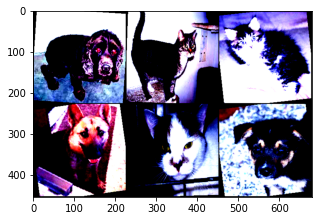

In [6]:
def preview_data(dataset, size=(8,8), havelabel=True):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    thisbatch = next(iter(dataloader))
    if havelabel:
        images, labels = thisbatch
    else:
        images = thisbatch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=size)
    plt.imshow(np.transpose(grid, (1,2,0)))
    if havelabel:
        print('labels: {}'.format(labels))
    
preview_data(dataset, (5,5))

## Model Constructing

In [7]:
model = torchvision.models.resnet50(pretrained=True)
# Load Parameters
for param in model.parameters():
    param.requires_grad = False
    
print("modifying...")
# set n output classes to len of dataset.classes list
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(dataset.classes))
print("modified")
# Define Loss
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.torch.optim.Adam(model.parameters(),lr=config.lr)
# to GPU
model = model.to(config.device)
# lr scheduler
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

modifying...
modified


## Training(FineTune)

In [8]:
import time

def train(model, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cpu', checkpoint_epochs=10):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    
    # will use thsi for graphing
    log_train_loss = []
    log_valid_loss = []
    log_train_acc = []
    log_valid_acc = []
    
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        
        model.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in tqdm(train_dataloader):
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            loss = criterion(preds, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()
        
        if valid_dataloader is not None:
            model.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in tqdm(valid_dataloader):
                    X = X.to(device)
                    y = y.to(device)
                    preds = model(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()
        
        if scheduler is not None: 
            scheduler.step()
            
        log_train_loss.append(f'{train_loss/len(train_dataloader.dataset):.2f}')
        log_train_acc.append(f'{100*train_accuracy/len(train_dataloader.dataset):.2f}')
        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')
        
        if valid_dataloader is not None:
            log_train_loss.append(f'{valid_loss/len(valid_dataloader.dataset):.2f}')
            log_train_acc.append(f'{100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
        
        if epoch%checkpoint_epochs==0:
            torch.save({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.pth.tar')
        
        print()
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return model, log_train_loss, log_valid_loss, log_train_acc, log_valid_acc

In [9]:
trained_model, train_loss, valid_loss, train_acc, valid_acc = train(model=model, criterion=criterion, optimizer=optimizer, scheduler=step_lr_scheduler, train_dataloader=train_loader, valid_dataloader=test_loader, epochs=25, device=config.device)

Training for 25 epochs on cuda
Epoch 1/25


100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Training loss: 0.49
Training accuracy: 76.43
Valid loss: 0.22
Valid accuracy: 97.80

Epoch 2/25


100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Training loss: 0.19
Training accuracy: 96.27
Valid loss: 0.13
Valid accuracy: 97.60

Epoch 3/25


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Training loss: 0.12
Training accuracy: 96.80
Valid loss: 0.11
Valid accuracy: 97.50

Epoch 4/25


100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Training loss: 0.10
Training accuracy: 97.10
Valid loss: 0.09
Valid accuracy: 97.50

Epoch 5/25


100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Training loss: 0.09
Training accuracy: 97.43
Valid loss: 0.08
Valid accuracy: 97.90

Epoch 6/25


100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Training loss: 0.08
Training accuracy: 97.57
Valid loss: 0.08
Valid accuracy: 97.60

Epoch 7/25


100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Training loss: 0.08
Training accuracy: 97.40
Valid loss: 0.08
Valid accuracy: 97.50

Epoch 8/25


100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Training loss: 0.07
Training accuracy: 97.83
Valid loss: 0.08
Valid accuracy: 97.90

Epoch 9/25


100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Training loss: 0.07
Training accuracy: 98.03
Valid loss: 0.08
Valid accuracy: 97.90

Epoch 10/25


100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Training loss: 0.07
Training accuracy: 98.03
Valid loss: 0.08
Valid accuracy: 98.10

Epoch 11/25


100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Training loss: 0.07
Training accuracy: 97.93
Valid loss: 0.08
Valid accuracy: 97.60

Epoch 12/25


100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Training loss: 0.07
Training accuracy: 97.93
Valid loss: 0.08
Valid accuracy: 98.00

Epoch 13/25


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Training loss: 0.07
Training accuracy: 98.10
Valid loss: 0.08
Valid accuracy: 97.50

Epoch 14/25


100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


Training loss: 0.07
Training accuracy: 98.17
Valid loss: 0.07
Valid accuracy: 97.80

Epoch 15/25


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Training loss: 0.07
Training accuracy: 97.67
Valid loss: 0.08
Valid accuracy: 97.90

Epoch 16/25


100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Training loss: 0.07
Training accuracy: 98.07
Valid loss: 0.07
Valid accuracy: 98.10

Epoch 17/25


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Training loss: 0.07
Training accuracy: 97.83
Valid loss: 0.08
Valid accuracy: 97.60

Epoch 18/25


100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Training loss: 0.07
Training accuracy: 97.87
Valid loss: 0.08
Valid accuracy: 98.10

Epoch 19/25


100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Training loss: 0.07
Training accuracy: 98.03
Valid loss: 0.08
Valid accuracy: 98.10

Epoch 20/25


100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Training loss: 0.07
Training accuracy: 97.83
Valid loss: 0.07
Valid accuracy: 97.80

Epoch 21/25


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Training loss: 0.07
Training accuracy: 98.03
Valid loss: 0.08
Valid accuracy: 97.60

Epoch 22/25


100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Training loss: 0.07
Training accuracy: 97.80
Valid loss: 0.07
Valid accuracy: 98.10

Epoch 23/25


100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Training loss: 0.07
Training accuracy: 97.97
Valid loss: 0.07
Valid accuracy: 98.20

Epoch 24/25


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Training loss: 0.07
Training accuracy: 97.53
Valid loss: 0.08
Valid accuracy: 98.00

Epoch 25/25


100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Training loss: 0.07
Training accuracy: 98.20
Valid loss: 0.08
Valid accuracy: 97.60

Total training time: 634.0 seconds


# Evaluate

In [10]:
def predict(x, model):
    x = model(x)
    return x

labels: tensor([0, 1, 0, 0, 0, 1])


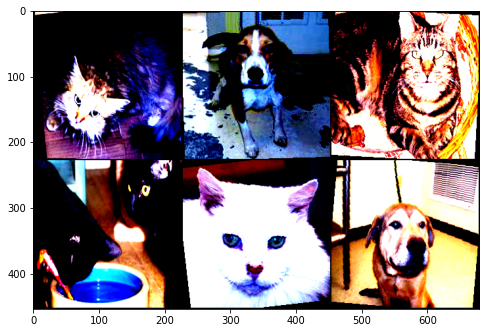

In [11]:
preview_data(test)

## Make Submission

In [12]:
import glob
import PIL
# Load Test
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(f'{path}/*.jpg')
        self.transform = transform

    def __getitem__(self, index):
        image_name =  os.path.basename(self.image_paths[index])
        image = PIL.Image.open(self.image_paths[index])
        # check if is RGB mode, if not -> convert (to fix the dimension problem)
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        if self.transform is not None:
            image = self.transform(image)
        return image, image_name

    def __len__(self):
        return len(self.image_paths)
    
test_data = TestDataset('./test', data_transform)
test_data = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [13]:
submission = pd.DataFrame(columns=['filename', 'class'])
sname = []
sclasses = [] 
for data in tqdm(test_data):
    image, image_name = data
    pred = predict(image.to(config.device), trained_model)
    pred_classes = config.classes_dict[f'{np.argmax(pred.cpu().detach().numpy())}']
    sname.append(image_name)
    sclasses.append(pred_classes)
    #print(image_name[0]) #img[0] use 0 because img come in batch we only want first one 
    #print(pred_classes)
submission['filename'] = sname
submission['class'] = sclasses
submission['filename'] = submission['filename'].map(lambda x: ''.join(x).split('.')[0]) # get rid of (name, ) format

100%|██████████| 800/800 [00:10<00:00, 78.83it/s]


In [14]:
submission.head(5)

,filename,class
0,d92e297a,cat
1,87922e51,cat
2,ea325c8e,cat
3,d4589099,cat
4,347f7b07,cat


In [15]:
submission.to_csv('./submission.csv', index=False) # make submission file

In [16]:
trained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 